In [1]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=3)

In [2]:
# Model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input   = torch.nn.Linear(3, 32)
        self.output  = torch.nn.Linear(32, 1)

    def forward(self, x):
        z = torch.tanh(self.input(x))
        z = self.output(z)
        return z

In [3]:
# Read data
df = pd.read_csv('C:/Users/tln229/Downloads/Python/1. Building/data/HVAC_B90_102_exp_10m_20210424.csv')
qrh = np.array(df['htg_valve_command']).reshape(-1,1)
msa = np.array(df['airflow_desired']).reshape(-1,1)

# LEAST SQUARE
ones = np.ones(msa.shape)
A = np.concatenate((qrh, ones), axis=1)
b = np.copy(msa)
p = np.linalg.lstsq(A, b, rcond=None)[0]

In [4]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x_data)
    
    # R^2 qrh
    r2_qrh = r2_score(testset.y_data, pred_Y)

    # R^2 msa
    pred_msa = pred_Y*p[0] + p[1]
    r2_msa = r2_score(testset.msa_data, pred_msa)
    
    # RMSE
    rmse = torch.sqrt(torch.mean(torch.square(pred_Y - testset.y_data)))
    return r2_qrh, r2_msa, rmse

In [5]:
# Create network
device = torch.device("cpu")
net = Net().to(device)

In [6]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, start=None, end=None):
    df = pd.read_csv(src_file)
    clg_sp       = np.array(df['clg_sp_current']).reshape(-1,1)[start: end]
    htg_sp       = np.array(df['htg_sp_current']).reshape(-1,1)[start: end]
    htg_clg_mode = 1*np.array(df['htg_clg_mode']).reshape(-1,1)[start: end]

    sp_k   = htg_sp*htg_clg_mode + clg_sp*(1-htg_clg_mode)
    Tz_k   = np.array(df['thermostat_room_temp']).reshape(-1,1)[start: end]
    qrh_k  = np.array(df['htg_valve_command']).reshape(-1,1)[start: end]
    qrh_k1 = np.array(df['htg_valve_command']).reshape(-1,1)[start+1: end+1]
    msa_k1 = np.array(df['airflow_desired']).reshape(-1,1)[start+1: end+1]
    tmp_x  = np.concatenate((sp_k, Tz_k, qrh_k), axis=1)
    
    self.x_data   = torch.tensor(tmp_x,  dtype=torch.float32)
    self.y_data   = torch.tensor(qrh_k1, dtype=torch.float32)
    self.msa_data = torch.tensor(msa_k1, dtype=torch.float32)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    inp  = self.x_data[idx]
    outp = self.y_data[idx]
    msa  = self.msa_data[idx]
    sample = {'inp':inp, 'outp':outp, 'msa':msa}
    return sample

# Create Dataset and DataLoader objects
src_file = 'C:/Users/tln229/Downloads/Python/1. Building/data/HVAC_B90_102_exp_10m_20210424.csv'
n_train  = 256
train_ds = Data(src_file, start=0, end=n_train)
test_ds  = Data(src_file, start=n_train, end=1600)

In [ ]:
# train model
max_epochs = 50000
loss_func  = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.002)

train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True)
R2_qrh = np.array([])
R2_msa = np.array([])
for epoch in range(0, max_epochs+1):
    net.train()
    loss  = 0
    count = 0
    for (_, batch) in enumerate(train_ldr):
        X    = batch['inp']
        Y    = batch['outp']

        optimizer.zero_grad()
        output = net(X)                    # compute the output of the Network
        loss_val = loss_func(output, Y)
        loss += loss_val.item()            # accumulate
        loss_val.backward()                # gradients
        optimizer.step()                   # update paramters
        count += 1

    net.eval()
    R2_qrh = np.append(R2_qrh, eval(net, test_ds)[0].item())
    R2_msa = np.append(R2_msa, eval(net, test_ds)[1].item())
    if(epoch%1000==0):
        print("epoch = %5d \t loss = %11.3f \t RMSE = %7.3f \t R2_qrh = %7.5f \t R2_msa = %7.5f" % 
              (epoch, loss/count, eval(net, test_ds)[2].item(), eval(net, test_ds)[0].item(), eval(net, test_ds)[1].item()))

In [ ]:
def plot(dataset, size):
    with torch.no_grad():
        pred_Y = net(dataset.x_data)

    plt.figure(figsize=size)
    plt.plot(dataset.y_data, 'b-',  label=r'$q_{rh}$ measured')
    plt.plot(pred_Y,         'r--', label=r'$q_{rh}$ predicted')
    plt.legend()
    plt.show()

RMSE: 0.9776281241856145
R2:   0.9777172694333771


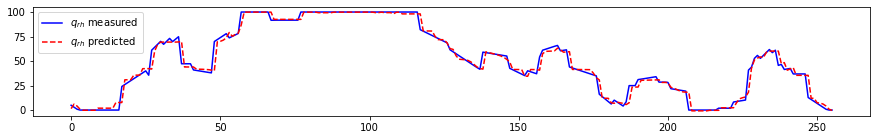

In [ ]:
net.eval()
print("RMSE:", eval(net, train_ds)[1].item())
print("R2:  ", eval(net, train_ds)[0].item())
plot(train_ds, (15, 2))

RMSE: 0.9662449071501672
R2:   0.9665651302759265


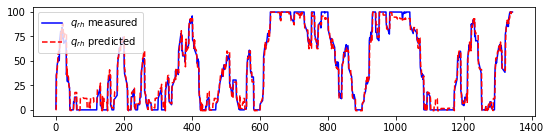

In [ ]:
net.eval()
print("RMSE:", eval(net, test_ds)[1].item())
print("R2:  ", eval(net, test_ds)[0].item())
plot(test_ds, (9, 2))

In [ ]:
print(np.argmax(R2_msa + R2_qrh))
z = np.argmax(R2_msa + R2_qrh)
print(R2_qrh[z])
print(R2_msa[z])

4877
0.9714539993562565
0.9709335794417422
